In [10]:
import pandas as pd


In [11]:
import pandas as pd
data_newfeature = pd.read_csv('Preprocessed Data.csv')



# Casual Inference 1: Marital Status Married vs. Total Purchased


In [12]:
import pandas as pd
import numpy as np
from causalml.inference.meta import LRSRegressor, XGBTRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [13]:
# All Puechases as Target
data_newfeature['Allpurchases'] = data_newfeature['NumWebPurchases'] + data_newfeature['NumCatalogPurchases'] + data_newfeature['NumStorePurchases']


#  treatment
data_newfeature['treatment'] = data_newfeature['Marital_Status_Married']

# control
control_columns = [
    'Marital_Status_Alone', 'Marital_Status_Divorced', 'Marital_Status_Single',
    'Education_Master','Marital_Status_Widow', 'Marital_Status_YOLO',
    'Age', 'Income', 'Is_Parent', 'Member_Year', 'Family_Size',
    'Education_Basic', 'Education_Graduation', 'Marital_Status_Together', 'Education_PhD'
]


X = data_newfeature[control_columns]
y = data_newfeature['Allpurchases']
treatment_binary = data_newfeature['treatment']

# train and test
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, y, treatment_binary, test_size=0.2, random_state=42)

# Model
lr_model = LRSRegressor()
xgb_model = XGBTRegressor()

# Train
lr_model.fit(X_train, treatment_train, y_train)
xgb_model.fit(X_train, treatment_train, y_train)

# estimate
predictions_lr = lr_model.predict(X_test)
predictions_xgb = xgb_model.predict(X_test)

# RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, predictions_lr))
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))

print(f"LR Model RMSE: {rmse_lr}")
print(f"XGB Model RMSE: {rmse_xgb}")

# cross validation ATE
def cross_validate_ate(estimator, X, treatment, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    ate_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        treatment_train, treatment_test = treatment.iloc[train_index], treatment.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, treatment_train, y_train)
        ate_estimate = estimator.estimate_ate(X_test, treatment_test, y_test)[0]
        ate_scores.append(ate_estimate)

    return np.mean(ate_scores), np.std(ate_scores)

# LRSRegressor ATE
ate_mean, ate_std = cross_validate_ate(lr_model, X, treatment_binary, y, cv=5)
print(f"LRSRegressor ATE: {ate_mean} (±{ate_std})")

# XGBTRegressor ATE
ate_mean, ate_std = cross_validate_ate(xgb_model, X, treatment_binary, y, cv=5)
print(f"XGBTRegressor ATE: {ate_mean} (±{ate_std})")

LR Model RMSE: 12.335760839047937
XGB Model RMSE: 15.433264485765557
LRSRegressor ATE: 1.7510108958210306 (±0.9624758406367943)
XGBTRegressor ATE: 0.20833951071444537 (±0.48540511039841466)


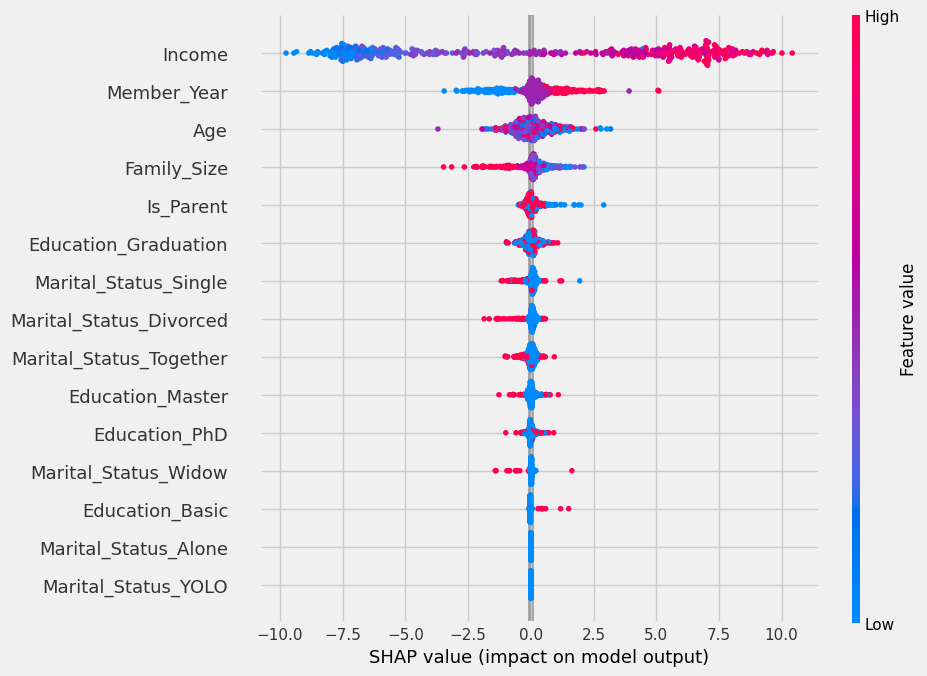

In [14]:
# Use the trained XGB model to obtain SHAP values for the test set
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Plot the SHAP values for high and low income
shap.plots.beeswarm(shap_values, max_display=30)

# Casual Inference 2: Complain vs. Total Purchased


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
X = data_newfeature[['Age', 'Member_Year', 'Family_Size', 'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD', 'Income', 'Is_Parent']]
data_newfeature['New_Purchases'] = data_newfeature['NumWebPurchases'] + data_newfeature['NumCatalogPurchases'] + data_newfeature['NumStorePurchases']
y = data_newfeature['New_Purchases']
treatment = data_newfeature['Complain']


numeric_features = ['Age', 'Member_Year', 'Family_Size', 'Income']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])


X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, y, treatment, test_size=0.2, random_state=42)


In [20]:
from sklearn.metrics import mean_squared_error
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
lrs = LRSRegressor()
lrs.fit(X_train_preprocessed, treatment_train, y_train)


lrs_ate = lrs.estimate_ate(X_train_preprocessed, treatment_train, y_train)
lrs_ite = lrs.predict(X_test_preprocessed)
lrs_rmse = np.sqrt(mean_squared_error(y_test, lrs_ite))
print(f"RMSE for LRSRegressor: {lrs_rmse}")

print(f"Estimated ATE using LRSRegressor: {lrs_ate[0]}")

RMSE for LRSRegressor: 15.329666158317139
Estimated ATE using LRSRegressor: [-0.56056929]


In [21]:
# Initialize and train the model using XGBTRegressor
from causalml.inference.meta import XGBTRegressor
xgbt = XGBTRegressor()
xgbt.fit(X_train_preprocessed, treatment_train, y_train)

# Estimate ATE and ITE
xgbt_ate = xgbt.estimate_ate(X_train_preprocessed, treatment_train, y_train)
xgbt_ite = xgbt.predict(X_test_preprocessed)

# Output results
xgbt_rmse = np.sqrt(mean_squared_error(y_test, xgbt_ite))
print(f"RMSE for XGBTRegressor: {xgbt_rmse}")
print(f"Estimated ATE using XGBTRegressor: {xgbt_ate[0]}")

RMSE for XGBTRegressor: 13.833679351602841
Estimated ATE using XGBTRegressor: [1.06547139]


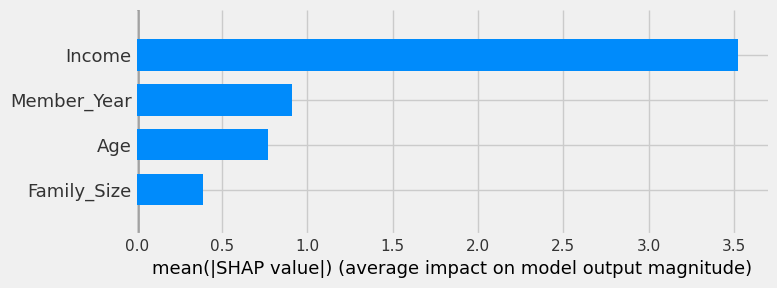

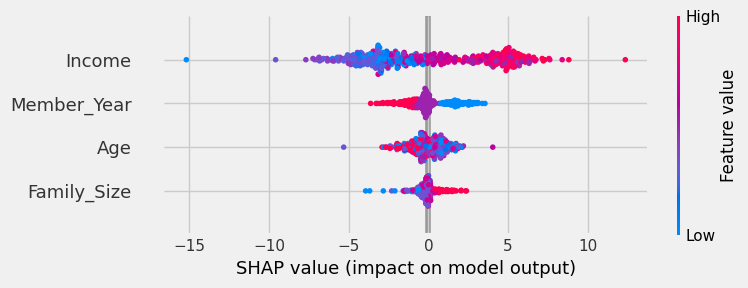

In [22]:
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


t_pred = xgbt_ite


xgb = XGBRegressor()
xgb.fit(X_test_preprocessed, t_pred)


explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_preprocessed)


feature_names = [
    'Age', 'Member_Year', 'Family_Size', 'Income', 'Total_Children', 'Is_Parent',
    'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD'
]


shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, plot_type="bar")


plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)

# Casual Inference 3: Income vs. Total Purchased

In [24]:
median_income = data_newfeature['Income'].median()
data_newfeature['High_Income'] = (data_newfeature['Income'] >= median_income).astype(int)

control_cols = ['Recency', 'MntWines', 'MntFruits',
                'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                'MntGoldProds', 'NumWebVisitsMonth',
                'Complain', 'Response', 'Member_Year',
                'Age',
                'Family_Size', 'Cmp_Attitude', 'Education_Basic',
                'Education_Graduation', 'Education_Master', 'Education_PhD',
                'Marital_Status_Alone', 'Marital_Status_Divorced',
                'Marital_Status_Married', 'Marital_Status_Single',
                'Marital_Status_Together', 'Marital_Status_Widow',
                'Marital_Status_YOLO']

# Creating Total_Purchases as Target in the updated DataFrame
data_newfeature['Total_Purchases'] = data_newfeature['NumWebPurchases'] + data_newfeature['NumCatalogPurchases'] + data_newfeature['NumStorePurchases']

X = data_newfeature[control_cols]
y = data_newfeature['Total_Purchases']

# Treatment variable from the updated DataFrame
treatment = data_newfeature['High_Income']

# Standardize the control variables
scaler = StandardScaler()

# Create a copy of the dataframe to avoid SettingWithCopyWarning
X_scaled = data_newfeature[control_cols].copy()
X_scaled[control_cols] = scaler.fit_transform(X_scaled)

# Now split your data
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X_scaled, y, treatment, test_size=0.2, random_state=2024
)


In [25]:
# Initialize models
lr_model = LRSRegressor()
xgb_model = XGBTRegressor()

# Train models
lr_model.fit(X_train, treatment_train, y_train)
xgb_model.fit(X_train, treatment_train, y_train)

# Make predictions
predictions_lr = lr_model.predict(X_test)
predictions_xgb = xgb_model.predict(X_test)

# Calculate RMSE for the models
rmse_lr = np.sqrt(mean_squared_error(y_test, predictions_lr))
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))
print(f"LR Model RMSE: {rmse_lr}")
print(f"XGB Model RMSE: {rmse_xgb}")

# Define a function to perform cross-validated ATE estimation
def cross_validate_ate(model, X, treatment, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=2024)
    ates = []

    for train_index, test_index in kf.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        treatment_train_kf, treatment_test_kf = treatment.iloc[train_index], treatment.iloc[test_index]
        y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_kf, treatment_train_kf, y_train_kf)
        ate_est = model.estimate_ate(X_test_kf, treatment_test_kf, y_test_kf)[0]
        ates.append(ate_est)
    return np.mean(ates), np.std(ates)

# Cross-validated ATE for LR model
ate_mean_lr, ate_std_lr = cross_validate_ate(lr_model, X_train, treatment_train, y_train, cv=5)
print(f"LRSRegressor ATE: {ate_mean_lr} (±{ate_std_lr})")

# Cross-validated ATE for XGB model
ate_mean_xgb, ate_std_xgb = cross_validate_ate(xgb_model, X_train, treatment_train, y_train, cv=5)
print(f"XGBTRegressor ATE: {ate_mean_xgb} (±{ate_std_xgb})")

LR Model RMSE: 11.147791486007968
XGB Model RMSE: 15.45312924198251
LRSRegressor ATE: 4.0743910040539415 (±0.5019651108255853)
XGBTRegressor ATE: 0.8828285635169653 (±0.4619878699998941)


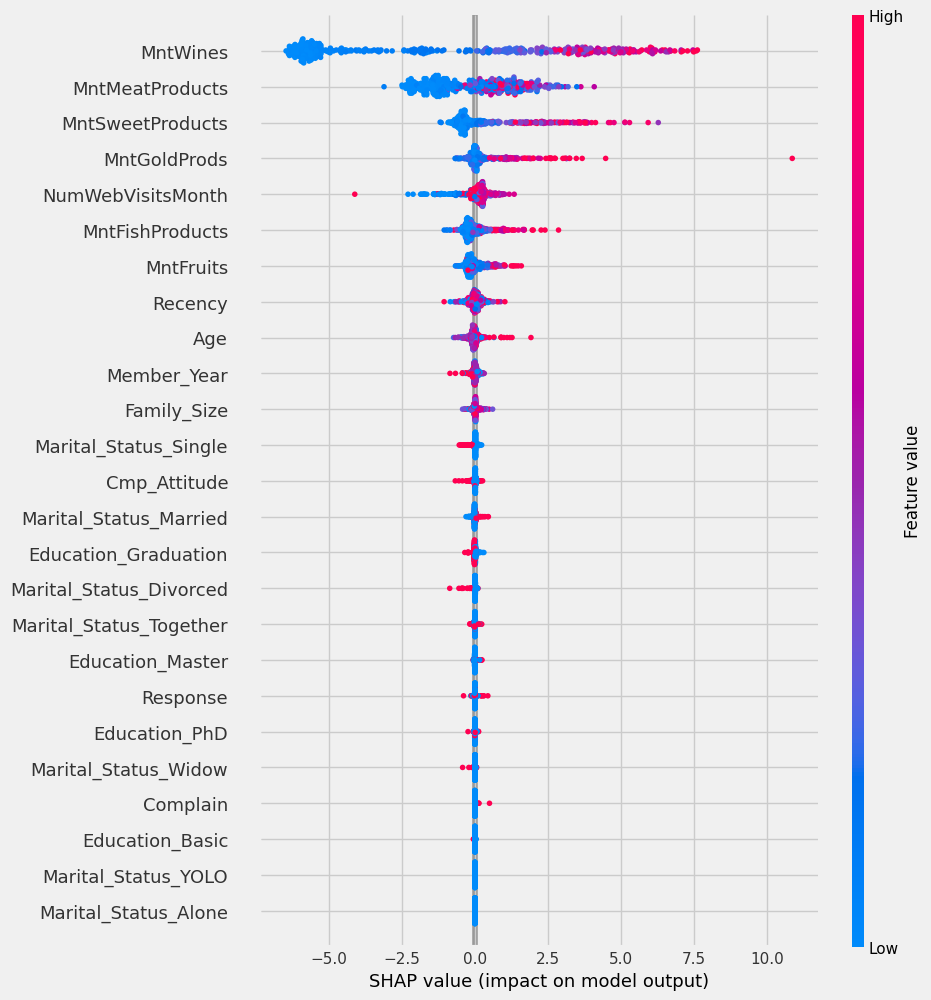

In [26]:
# Use the trained XGB model to obtain SHAP values for the test set
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Plot the SHAP values for high and low income
shap.plots.beeswarm(shap_values, max_display=30)